# Time Series Analysis
In this notebook, we will create a trading strategy using the ARIMA model on a Bank of America Time Series.

***
## Financial Background
#### Trading Strategy using the ARIMA model
* We know that time series data has a peculiar characteristic which is the persistence in successive observations. This means that previous values have some influence on the present value. We can use that characteristic to perform price forecasting. 
* To perform price forecasting, we can use [autoregressive models **(AR)**](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/) or [moving average models **(MA)**](https://en.wikipedia.org/wiki/Moving-average_model) or even better combine both. 
  * **Autoregressive models** are processes where the current value is a linear combination of past/lagged observations.
  * **Moving Average models** are processes where the current value is a linear combination of past error terms. 
* **$AR(p)$** models attempt to explain the [mean reversion](https://www.investopedia.com/terms/m/meanreversion.asp) and trending behaviors that we observe in asset prices.
* **$MA(q)$** models try to capture the idiosyncratic shocks that are observed in financial markets. A [white noise process](https://en.wikipedia.org/wiki/White_noise) models these shocks quite well. We can think of events like terrorist attacks, earnings surprises, sudden political changes, etc. as the random shocks affecting the asset price movements.
* A more realistic model called the [Auto Regresive Moving Average **(ARMA)**](https://www.statisticshowto.com/arma-model/) combines the characteristics of $AR$ and $MA$.
* However, all the models described above will only work or have good explanatory and predictive power only if the time series is [stationarity](https://otexts.com/fpp2/stationarity.html). Meaning that time series' statistical properties (mean, variance, covariance) are constant throughout time.
* We can perform an [augmented fuller dicker test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to check if the time series is stationary or not. In the case the time series is not stationary, we can convert it into stationary by differencing the time series. 
* This is where [ARIMA models](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) come in handy. ARIMA models perform an order of i in differencing the time series and then perform the ARMA model. 
* Once we have a good model, we can forecast the price in the time series and generate trading signals. 
* The trading strategy is simple: 
     * If our current predicted price increased, then we go long (we buy)
     * otherwise we go short (we sell or short-sell)

***
## Importing libraries 
Importing the relevant libraries for coding the strategy based on the ARIMA model. 
* Numpy library will help us with quick vectorized calculations.
* Pandas is used for taking advantage of its powerful data frames and matplotlib.pyplot is used to plot the price time series as well as the cumulative returns of the strategy.
* We will also import the adfuller function from the statsmodels.tsa.stattools to check if the time series is stationary. 
* For the statistical analysis, we will import the ARIMA function from the statsmodels.tsa.arima_model to perform an ARIMA model and the functions plot_acf and plot_pacf from the library statsmodels.graphics.tsaplots to check for autocorrelation and partial autocorrelation behaviors on the time series. 
* The library yfinance will be used to download intraday stock data. 
* The pyfolio library for performing a quick backtest on the strategy returns.
* For better dates format we used the mdates function from the module matplotlib.dates 
* For calculating the different types of error we used the sklearn.metrics library. 


In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller 

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.dates as mdates
import yfinance as yf
import pyfolio as pf

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt

## Download and gather the data
We will download the data from yahoo finance. The ticker for Bank of America is "BAC" and we will use intraday data from the whole year 2020.

In [2]:
df = yf.download( "BAC", start = "2020-01-01", end = "2020-12-31")[['Adj Close']]
df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2020-01-02,33.887878
2020-01-03,33.184258
2020-01-06,33.136715
2020-01-07,32.918018
2020-01-08,33.250820


### Check if the data has any missing values. 

In [3]:
null_values = int( df.isnull().sum() )

print(f"There are {null_values} missing values on BAC asset" )

There are 0 missing values on BAC asset


### Check if the time series is stationary 
* [Augmented fuller dicker test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test), a test for checking stationarity on time series can help us with this task. 
  * The test makes the assumption that there is a unit-root in the univariate process in the presence of serial correlation. In simple terms, the null hypothesis will be the given series is not stationary. Thus, the alternative hypothesis is the series is stationary. 
     * If we can reject the null hypothesis in favor of the alternative hypothesis (meaning the p-value is less than 0.05), then we can conclude that the time series is indeed stationary. 

In [4]:
def check_for_stationarity(df, name):
    '''
    Description: Check if a time series with its respected ticker name is stationary or not. 
                 It will print whether or not the time series is stationary. 
    
    Keyword arguments:
    df -- dataFrame containing the time price series
    name -- The ticker of the time series
    
    @return none
    '''
    adf_test = adfuller(df)  # perform an augmented dicker-fuller test for checking stationarity.
    
    if ( adf_test[1] < 0.05 ): # the p-value is less than 0.05, which means we reject the null hypothesis in favor of the
                            # alternative hypothesis.
        print(f"The time series for {name} is stationary")
    else:
        print(f"The time series for {name} is Not stationary")

### Plotting the time series
Recall that if a time series is not stationary, then its statistical properties (mean or variance) are changing throughout time.

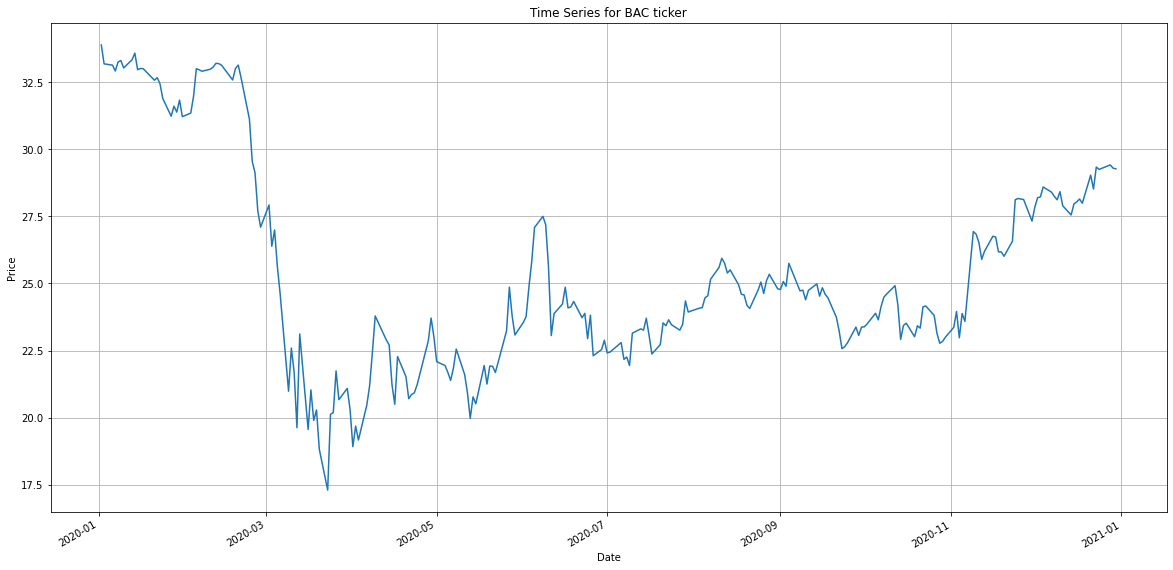

In [5]:
df['Adj Close'].plot(figsize = (20,10), grid = True, title = "Time Series for BAC ticker") 
plt.ylabel("Price")
plt.xlabel("Date")
plt.show()

From the plot the time series looks not stationary, but let's confirm that assumption by applying the adf test.

In [6]:
check_for_stationarity(df, 'BAC')

The time series for BAC is Not stationary


### Convert the non-stationary time series to a stationary time series
Our assumption was correct. **The time series is not stationary.** Hence, we need to convert it to a stationary time series before we can apply the ARMA model. One simple way to achieve this is by differencing where we just subtract the previous price from the current price.

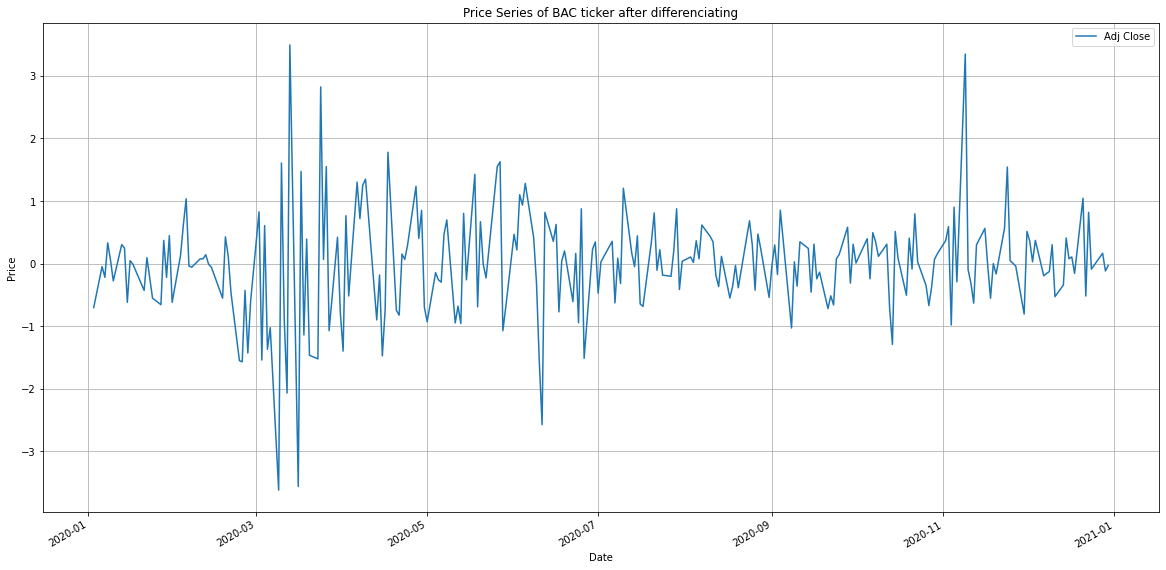

In [7]:
df.diff().dropna().plot( figsize = (20,10), grid = True, title = "Price Series of BAC ticker after differenciating" ) 
plt.ylabel("Price")
plt.xlabel( "Date" )
plt.show()

From the plot, the time series after differencing looks stationary ,but let's confirm that assumption by applying the adf test.

In [8]:
check_for_stationarity( df.diff().dropna(), "BAC_differentiated"  )

The time series for BAC_differentiated is stationary


Since it required only one differentiation to make the time series stationarity, we can use an order of one. Making our ARIMA model as 
ARIMA(p,1,q) where 1 is the order of the integrated term.

### Find the order of AR and MA
Now we need to find the value parameters p and q.  We can look for significant correlation lags in the partial autocorrelation and autocorrelation plots. Significant correlation lags can be used as parameters of p and q.  

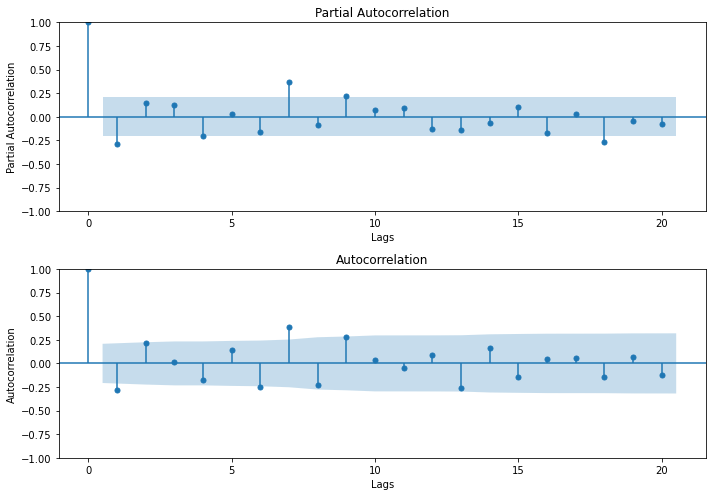

In [9]:
# Find the order of AR and MA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

rolling_window = 90    # we are going to use 90 days data

# Plot Partial Autocorrelation Function
plot_pacf(df['Adj Close'][:rolling_window].diff().dropna(), lags=20, ax=ax1)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Partial Autocorrelation')

# Plot Autocorrelation Function
plot_acf(df['Adj Close'][:rolling_window].diff().dropna(), lags=20, ax=ax2)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Autocorrelation')

plt.tight_layout()
plt.show()

From the plot above, we can see that there is a statistically significant lag at the first and seventh lag. After the seventh lag, all of the lags are statistically insignificant for both the ACF and PACF. 

Therefore, some good choices as ARIMA model are:
               
   * ARIMA( p = 1, d = 1, q = 1)  
   * ARIMA( p = 7, d = 1, q = 1)
   * ARIMA( p = 1, d = 7, q = 1) 
   * ARIMA( p = 7, d = 7, q = 1)

We know that if we increase the value of the parameters p and q, the ARMA model will need more estimated parameters. Therefore, an increase in the complexity of the model might result in overfitting. Since we want to avoid overfitting, we chose the first model and see its performance.

### Model ARIMA(1,1,1) 

In [10]:
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima.model.ARMA',
                        FutureWarning)

# Fit ARIMA model
model = ARIMA(df['Adj Close'][:rolling_window], order=(1, 1, 1))
model_fit_0 = model.fit()
print(model_fit_0.params.round(2)) #let's look at the parameters

ar.L1    -0.49
ma.L1     0.23
sigma2    1.10
dtype: float64


From the output above, we can see that the model becomes
$$ ARIMA(1,1,1) = y_t = 1.11 - 0.49y'_{t-1} + 0.23\epsilon_{t-1} + \epsilon_t$$

### Forecast the time series

In [11]:
def predict_price_ARIMA(train_data):
    ''' 
    Description: Function that given a training data set performs an ARIMA model and perform the forecasting
    
    Keyword arguments:
    train_data -- dataFrame containing the adjusted close price of the time series
    
    @return Forecasting price
    '''
    # Define model
    model = ARIMA(train_data, order=(1, 1, 1))
    
    # Fit the model
    try:
        model_fit = model.fit(start_params = model_fit_0.params )
        # Make the forecast and return the predicted price
        return model_fit.forecast().iloc[-1]
    except:# something went wrong and we couldn't fit the model and make a prediction
        pass

In [12]:
# Predict the price using `predict_price_ARIMA` function
df['predicted_price'] = df['Adj Close'].rolling(rolling_window).apply(predict_price_ARIMA)

# Shift the predicted price by 1 period since this is a prediction for the next day
df['predicted_price'] = df['predicted_price'].shift(1)

## Evaluate model performance

You can check the performance of the model by calculating the error metrics and residual analysis.

In [13]:
def model_performance(observed, predicted):
    """
    Description: Function that given the obeserved and predicted prices, calculates and display the Mean Absolute Error, 
                 Squared Error, Root Mean Squared Error and Mean Absolute Percentage Error by comparing the actual or 
                 observed price with our forecasting price. Also, it plots the predicted vs observed prices, the residuals
                 and performs an autocorrelation of the residuals.
    
    Keyword arguments: 
    observed  -- dataFrame containing the observed price 
    predicted -- dataFrame containing the forecasting price
    
    @return None
    """
    
    # Mean Absolute Error
    mae = mean_absolute_error(observed, predicted)
    print('The Mean Absolute Error is %.2f' % mae)

    # Mean Squared Error
    mse = mean_squared_error(observed, predicted)
    print('The Mean Squared Error is %.2f' % mse)

    # Root Mean Squared Error
    rmse = sqrt(mean_squared_error(observed, predicted))
    print('The Root Mean Squared Error is %.2f' % rmse)

    # Mean Absolute Percentage Error
    mape = 100 * ((observed-predicted)/observed).abs().mean()
    print('The Mean Absolute Percentage Error is %.2f' % mape)

    # Residuals
    residuals = observed - predicted
    labels = observed.index
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 11)) # set 3 subplots
    
    # Plot the predicted and observed price
    observed.plot(ax=ax1, color='purple')
    predicted.plot(ax=ax1, color='green')
    ax1.set_ylabel('Price')
    ax1.set_title('Predicted Vs. Observed')
    
    # Plot the residuals
    ax2.fill_between(residuals.index, residuals.values, color='red')
    ax2.set_ylabel('Error')
    ax2.set_xlabel('Date')
    ax2.set_title('Residuals')
    ax2.set_xticklabels(labels, rotation=45, ha='right')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))
    _= plt.xticks(rotation=45)
    
    # Autocorrelation plot of residuals
    plot_acf(residuals, ax=ax3, color='blue')
    ax3.set_xlabel('Lags')
    ax3.set_ylabel('Autocorrelation')
    ax3.set_title('Autocorrelation of Residuals')

    plt.tight_layout()
    plt.show()

The Mean Absolute Error is 0.48
The Mean Squared Error is 0.46
The Root Mean Squared Error is 0.68
The Mean Absolute Percentage Error is 1.96


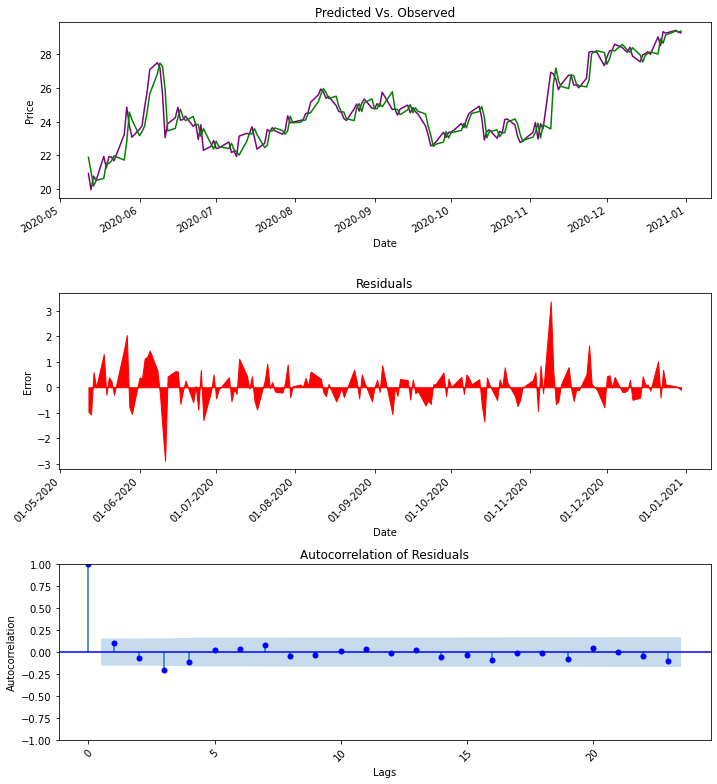

In [14]:
# call the model_performance function and see the model's performance
model_performance(df['Adj Close'].iloc[rolling_window:],
                  df['predicted_price'].iloc[rolling_window:])

From the above output, we can conclude that:
  
  * The types of error calculations or error metrics are low. That's a good sign since the purpose of the model is to minimize those errors and to stay as close as possible to the actual values. We can even confirm that from the plot predicted vs observed. 
  * The residual plot looks like white noise since its statistical properties appear constant. We know that white noise although is completely random, still has a constant mean and constant variance. 
  * However, when we look at the autocorrelation plot, we can see some autocorrelation at the third lag indicating that our model can be improved.

### Develop the strategy based on the ARIMA(1,1,1) 
From the ARIMA model, we generated predictions on the stock prices. We can create trading signals from those predictions.
The strategy is simple. If there was an increase in our prediction prices, then we go long; otherwise, we go short.

In [15]:
# Create trading signal
df['signal'] = np.where(df.predicted_price.shift(1) <
                          df.predicted_price, 1, -1) # if there was an increase on the predicted price 
                                                   # go long otherwise go short. 

# calculate the returns
df['returns'] = df['Adj Close'].pct_change()

# Get the returns of our strategy
df['strategy_returns'] = df.signal.shift(1)*df.iloc[rolling_window:].returns

## Analyze the Strategy Performance
We defined a function that calculates the Sharpe ratio, the cumulative returns, and the max drawdowns of the strategy. Also, it plots the cumulative returns and the drawdown of the strategy.

In [16]:
def analyse_strategy(strategy_returns):    
    '''
    Description: Function that takes a dataFrame containing the strategy's returns to calculate
                 the Sharpe ratio, cummulative returns, and max drawdown of the strategy. Also, 
                 shows plots of the cumulative returns and the drawdowns of the strategy
    
    Keyword arguments:
    strategy_returns -- dataFrame containing the strategy's returns
    
    @return None
    
    '''
    
    # calculate the sharpe_ratio
    sharpe_ratio = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)

    # Cumulative Returns
    cumulative_returns = (strategy_returns+1).cumprod()
    
    # ---------- Drawdowns calculations -------------------
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cumulative_returns.dropna())
    # Ensuring that the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = 100*((cumulative_returns)/running_max - 1)

    # Calculate the maximum drawdown
    max_dd = drawdown.min()

    # Print the Sharpe Ratio, Cumulative Returns and the Maximum Drawdown of the strategy
    print('The Sharpe Ratio is %.2f' % sharpe_ratio)
    print('The cumulative return is %.2f' % (
      ((cumulative_returns[-1])-1)*100) + "%") 
    print("The maximum drawdown is %.2f" % max_dd + "%")

    # Plotting the results
    labels = strategy_returns.index
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7))

    # Plot the cumulative strategy returns
    ax1.plot(cumulative_returns, color='b')
    ax1.set_title('Cumulative Returns', fontsize=14)
    ax1.set_ylabel('Cumulative Returns', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))
   
    # Plot the drawdowns of the strategy
    ax2.plot(drawdown, color='red')
    # Fill in-between the drawdown
    ax2.fill_between(drawdown.index, drawdown.values, color='red')
    ax2.set_title('Strategy Drawdown', fontsize=14)
    ax2.set_ylabel('Drawdown (%)', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y"))
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter("%d-%m-%Y"))

    plt.tight_layout()
    plt.show()
    

The Sharpe Ratio is 0.87
The cumulative return is 20.30%
The maximum drawdown is -20.50%


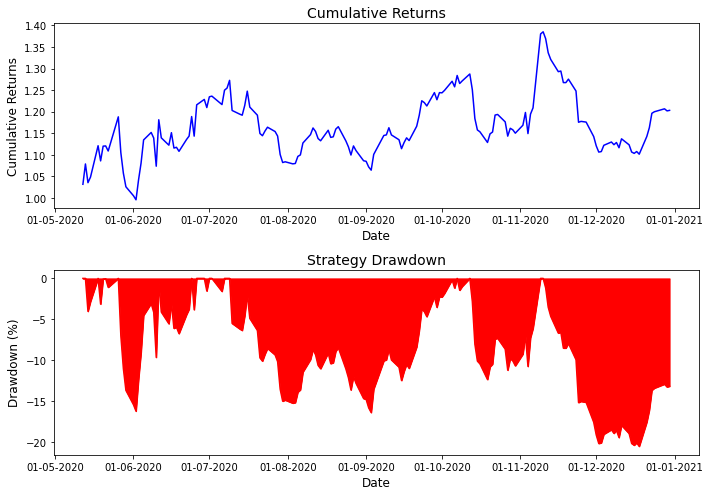

In [17]:
# Call the function analyse_strategy and print the performance of the strategy
analyse_strategy(df['strategy_returns'].iloc[rolling_window:]) 

### Perform a backtest of the strategy by using pyfolio

Start date,2020-01-02
End date,2020-12-30
Total months,12
,Backtest
Annual return,20.3%
Cumulative returns,20.3%
Annual volatility,43.6%
Sharpe ratio,0.87
Calmar ratio,0.99
Stability,0.14
Max drawdown,-20.5%


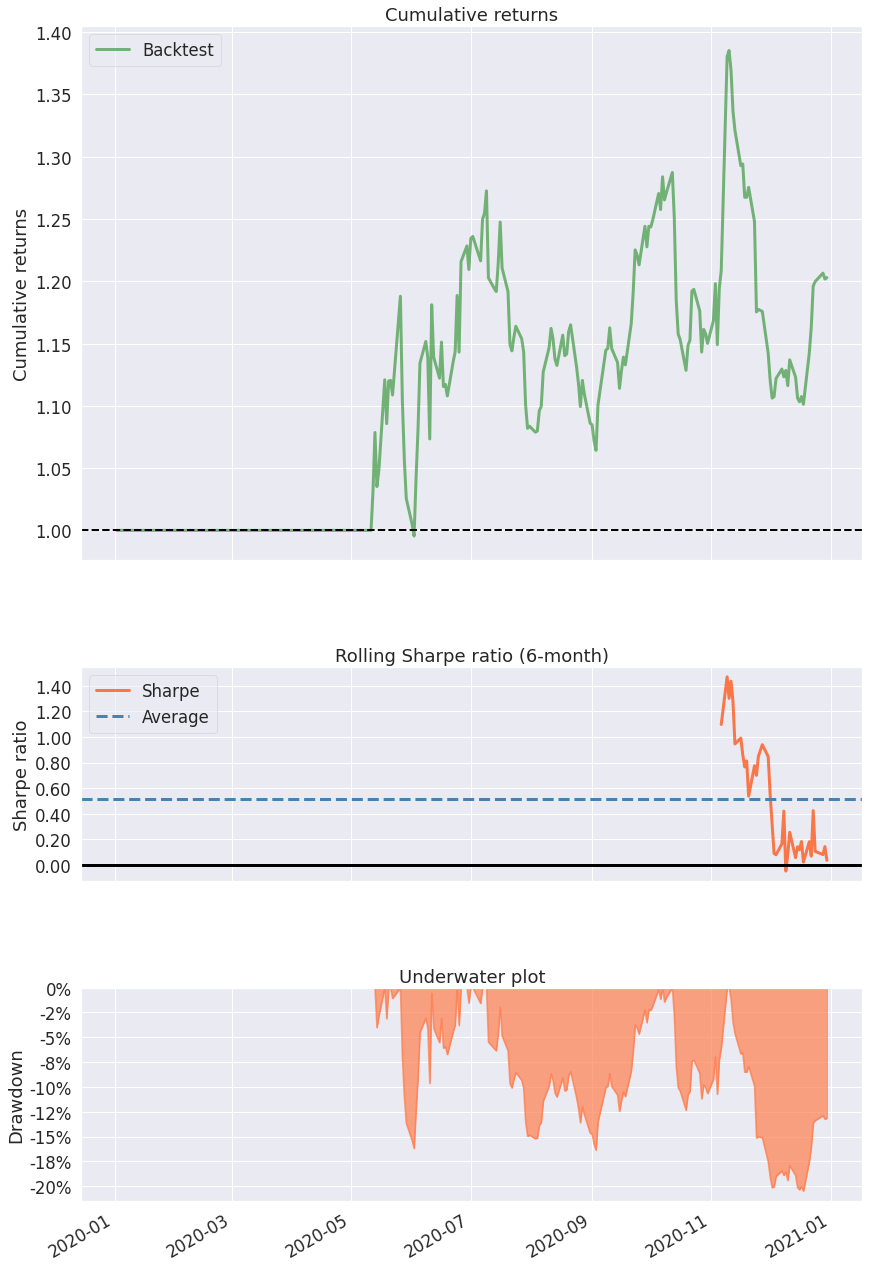

In [18]:
# Analyse the strategy results with pyfolio by passing the daily returns
pf.create_simple_tear_sheet( df['strategy_returns']) 

## Conclusion

* The performance of the trading strategy by predicting stock prices using the ARIMA model was acceptable.
* Without taking into consideration transaction costs and tax fees, the cumulative return of the strategy over a year was a decent 20.0 %
* However the annual volatility was extremely high 43.7%. Confirming that it was a very risky strategy.Nonetheless, we need to remember that we only use one asset in the construction of the portfolio. If we wanted to improve the risk of the strategy, we will have to incorporate more assets and make the portfolio diversified. 
* Since the Sharpe ratio represents the returns we are getting for each unit of risk taken and our annual volatility was high, our Sharpe ratio was low. It was lower than one (0.86). We can improve the strategy by diversifying our portfolio. 
* The Sortino ratio which only penalizes falling returns had a decent value. 
* The max drawdown of the strategy was -20.5 %
* Overall, the performance of the strategy was acceptable and we know that we can improve the strategy by diversifying our portfolio. 

***
## AI Meme
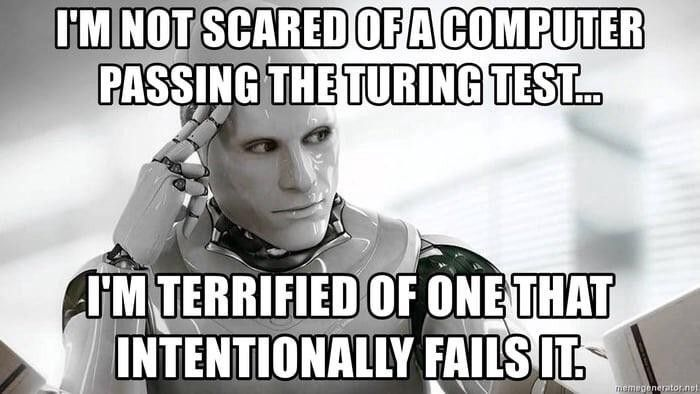